In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

data_puno = pd.read_csv('..\Databases\peru_2018_2021.csv')
data_puno = data_puno.loc[data_puno.dep==21]

In [2]:
# Set the random seed for reproductible results
#Train test split
np.random.seed(0)

test = data_puno.loc[data_puno.year==2021]
train = data_puno.loc[data_puno.year<2021]

y_train, y_test = train["disasters_risk"], test["disasters_risk"]
x_train, x_test = train["disasters_risk"], test["disasters_risk"]

x_train = pd.concat([train.iloc[:,9:-3], train['gpc']], axis=1)
x_test = pd.concat([test.iloc[:,9:-3], test['gpc']], axis=1)

In [78]:
clf = SGDClassifier(n_jobs=1, loss='log_loss', random_state=0, max_iter=1000, shuffle=True, learning_rate='optimal')


pipe = Pipeline([('Scaler', RobustScaler()), ('ENLR', clf)])

# Sensitivity True positive rate
def sensitivity(y_true,y_predicted):
    cm = confusion_matrix(y_true, y_predicted)
    if (cm[1,1]+cm[1,0])==0:
        sensitivity=0
    else:
        sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    return sensitivity


In [79]:
def BSCV(K, n_iter, alpha, pipe):
    
    #Cost metric
    def cost_metric(y_true,y_predicted):
        cost_metric = alpha*matthews_corrcoef(y_true,y_predicted) + (1-alpha)*sensitivity(y_true,y_predicted)
        return cost_metric

    cv = RepeatedKFold(n_splits=K, n_repeats=2, random_state=0)
  
    param_grid = {
                "ENLR__penalty": Categorical(['l2', 'l1', 'elasticnet']),
                "ENLR__alpha": (1e-2, 1e+2, 'log-uniform'),
                "ENLR__l1_ratio": Real(0, 1, prior='uniform'),
                }

    search_ddnn = BayesSearchCV(random_state=0, estimator=pipe, search_spaces=param_grid, 
                        scoring=make_scorer(cost_metric), cv=cv, n_jobs=-1, verbose=10,
                        n_iter=n_iter, return_train_score=True,
                        optimizer_kwargs={'base_estimator': 'GP', 'initial_point_generator': 'lhs'},
                        n_points=2, pre_dispatch='1*n_jobs')
    return search_ddnn


## Running this cell will perform RSCV

In [80]:
import time
start = time.time()

n_iter = 50
K= 10
alpha = 0.45
repeats=2
ENLR_results1 =  BSCV(K=K, n_iter=n_iter, alpha=alpha, pipe=pipe).fit(x_train, y_train)

Total_time = (time.time() - start)
print("Training time: ", Total_time, " seconds")


Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for eac

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 2 candidates, totalling 40 fits
Training time:  28.99899125099182  seconds


Sensitivity:  0.7775280898876404
Mathews Correlation Coefficient:  0.47475821966852566


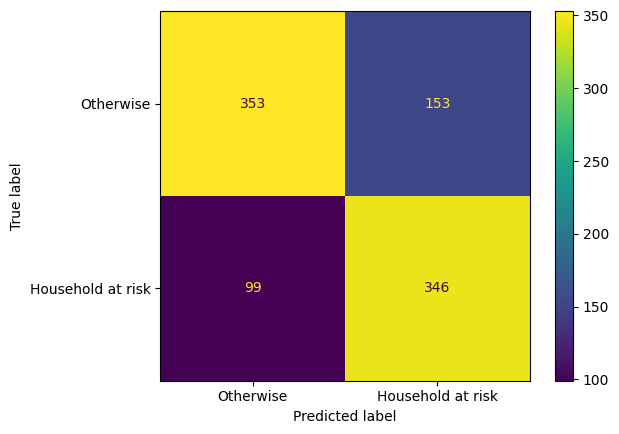

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = ENLR_results1.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=ENLR_results1.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Otherwise", "Household at risk"])
disp.plot()


print('Sensitivity: ', sensitivity(y_test, predictions))
print('Mathews Correlation Coefficient: ', matthews_corrcoef(y_test, predictions))

In [83]:
import time
start = time.time()

n_iter = 50
K= 10
alpha = 1 #All the importance to MCC
repeats=2
ENLR_results2 =  BSCV(K=K, n_iter=n_iter, alpha=alpha, pipe=pipe).fit(x_train, y_train)

Total_time = (time.time() - start)
print("Training time: ", Total_time, " seconds")

Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for eac

Sensitivity:  0.7752808988764045
Mathews Correlation Coefficient:  0.4590142136643567


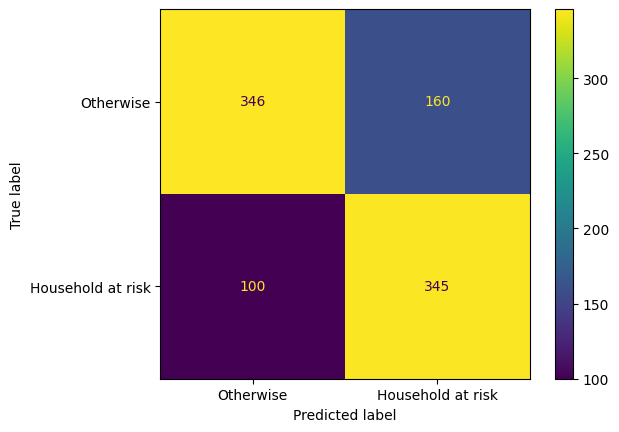

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = ENLR_results2.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=ENLR_results2.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Otherwise", "Household at risk"])
disp.plot()


print('Sensitivity: ', sensitivity(y_test, predictions))
print('Mathews Correlation Coefficient: ', matthews_corrcoef(y_test, predictions))

In [85]:
import pickle
filename1 = 'ENLR_puno_cost.sav'
filename2 = 'ENLR_puno.sav'
pickle.dump(ENLR_results1.best_estimator_, open(filename1, "wb"))
pickle.dump(ENLR_results2.best_estimator_, open(filename2, "wb"))

# Interpreting

In [102]:
pd.DataFrame(ENLR_results1.best_estimator_['ENLR'].coef_).T
ENLR_results1.best_estimator_.feature_names_in_

feature_importances = pd.concat([pd.Series(ENLR_results1.best_estimator_.feature_names_in_), pd.DataFrame(ENLR_results1.best_estimator_['ENLR'].coef_).T], axis=1)
feature_importances.columns = ['Features', 'Importances']


<AxesSubplot: xlabel='Importances', ylabel='Features'>

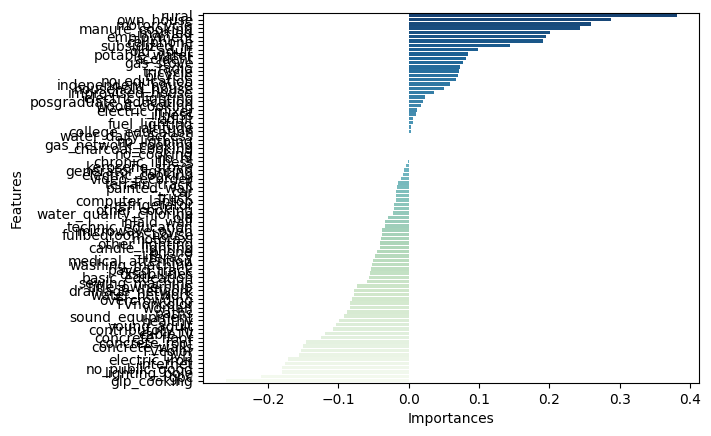

In [109]:
#x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state=0, test_size=0.2, stratify=Y)
#ENLR_results1.best_estimator_.fit(x_train, y_train)
import seaborn as sns

sorted_results = feature_importances.sort_values(by=['Importances'], ascending=False)


sns.barplot(data=sorted_results, y='Features', x='Importances', palette='GnBu_r')

Text(0, 0.5, 'Probability of being at risk')

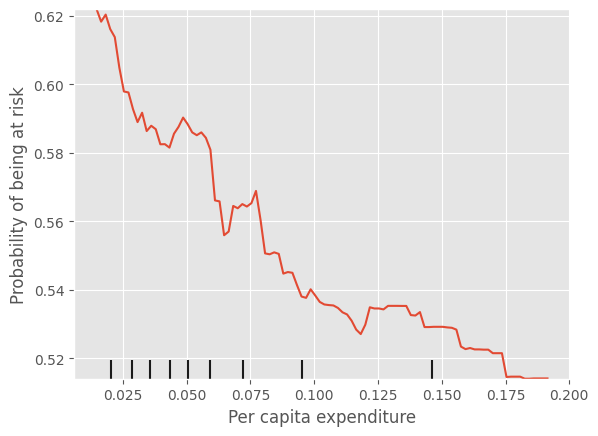

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
plt.style.use('ggplot')
partial_dependencies = PartialDependenceDisplay.from_estimator(winner_model, x, features=['gpc']
                                        , response_method='predict_proba', method='brute')
plt.xlabel('Per capita expenditure')
plt.ylabel('Probability of being at risk')

Text(0, 0.5, 'Probability of being at risk')

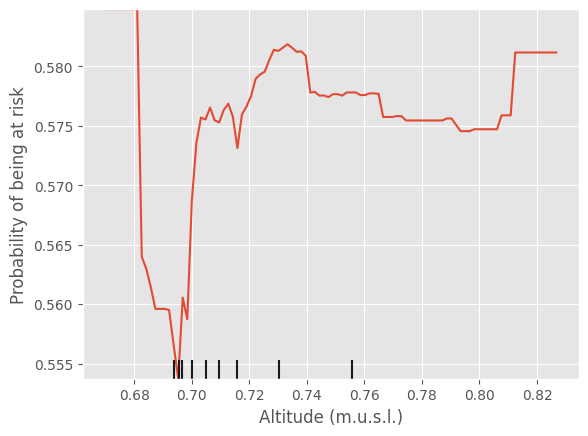

In [ ]:
PartialDependenceDisplay.from_estimator(winner_model, x, features=['altura']
                                        , response_method='predict_proba', method='brute')
plt.xlabel('Altitude (m.u.s.l.)')
plt.ylabel('Probability of being at risk')

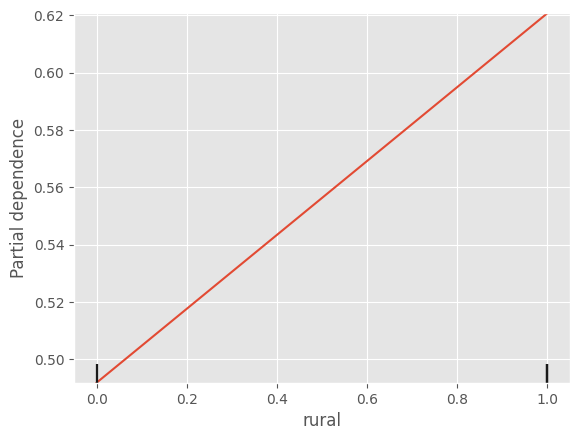

In [ ]:
PartialDependenceDisplay.from_estimator(winner_model, X=x, features=['rural']
                                        , response_method='predict_proba', method='brute')

In [ ]:
from sklearn.inspection import partial_dependence
resolution = 100

individual_conditional_expectations = (partial_dependence(winner_model, features=['gpc'], X=x, percentiles=(0.05,0.95),
                                grid_resolution=resolution, kind='individual'))

partial_dependencies = pd.DataFrame(individual_conditional_expectations['individual'].reshape(1106,resolution)
            , columns=individual_conditional_expectations['values'])

conditional_expectation = {'mean': [], 'std': []}

for i in np.arange(0,100, 1):
    conditional_expectation['mean'].append(partial_dependencies.iloc[:,i].mean())
    conditional_expectation['std'].append(partial_dependencies.iloc[:,i].std()**2)

conditional_expectation = pd.DataFrame(conditional_expectation)

<AxesSubplot:>

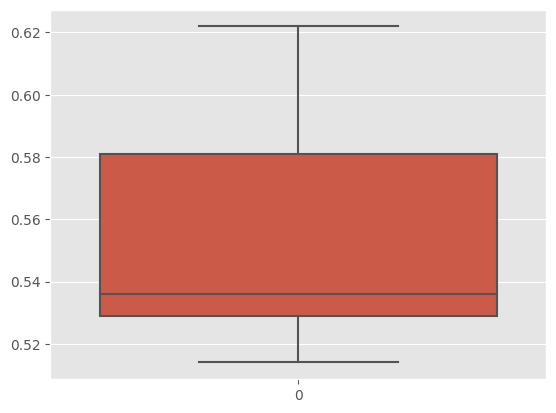

In [ ]:
sns.boxplot(conditional_expectation['mean'])

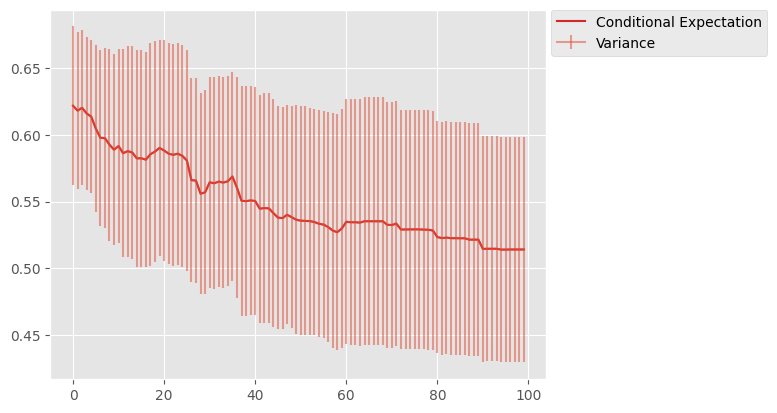

In [ ]:
plt.plot(conditional_expectation.index, conditional_expectation['mean'], color='tab:red', label='Conditional Expectation')
plt.errorbar(conditional_expectation.index, conditional_expectation['mean'], yerr=conditional_expectation['std'], alpha=0.5, label='Variance')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Trade-off between resolution and variance, more resolution implies more variance over each point of the Grid

In [ ]:
individual_conditional_expectations['values']

[array([0.01469531, 0.01648074, 0.01826617, 0.0200516 , 0.02183703,
        0.02362245, 0.02540788, 0.02719331, 0.02897874, 0.03076416,
        0.03254959, 0.03433502, 0.03612045, 0.03790587, 0.0396913 ,
        0.04147673, 0.04326216, 0.04504759, 0.04683301, 0.04861844,
        0.05040387, 0.0521893 , 0.05397472, 0.05576015, 0.05754558,
        0.05933101, 0.06111644, 0.06290186, 0.06468729, 0.06647272,
        0.06825815, 0.07004357, 0.071829  , 0.07361443, 0.07539986,
        0.07718529, 0.07897071, 0.08075614, 0.08254157, 0.084327  ,
        0.08611242, 0.08789785, 0.08968328, 0.09146871, 0.09325414,
        0.09503956, 0.09682499, 0.09861042, 0.10039585, 0.10218127,
        0.1039667 , 0.10575213, 0.10753756, 0.10932299, 0.11110841,
        0.11289384, 0.11467927, 0.1164647 , 0.11825012, 0.12003555,
        0.12182098, 0.12360641, 0.12539184, 0.12717726, 0.12896269,
        0.13074812, 0.13253355, 0.13431897, 0.1361044 , 0.13788983,
        0.13967526, 0.14146069, 0.14324611, 0.14

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit_transform(data_puno['gpc'].values.reshape(-1, 1))
index = scaler.inverse_transform(pd.DataFrame(individual_conditional_expectations['values'][0], columns=['gpc']))

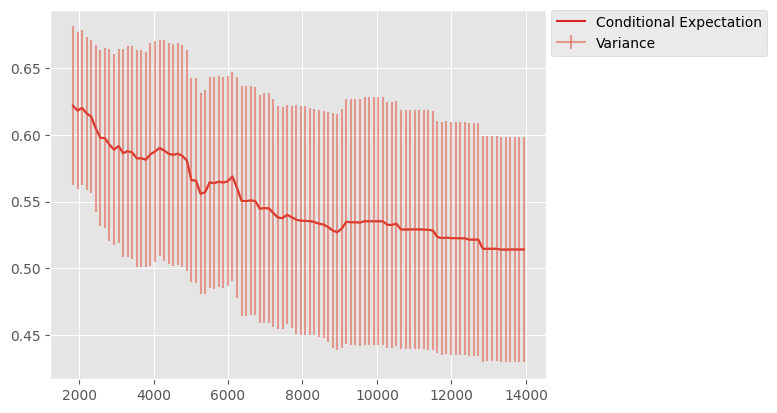

In [ ]:
plt.plot(index, conditional_expectation['mean'], color='tab:red', label='Conditional Expectation')
plt.errorbar(index, conditional_expectation['mean'], yerr=conditional_expectation['std'], alpha=0.5, label='Variance')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)